## Loading basic libraries

In [1]:
%%capture
try:
    import pandas  # noqa: F401
except ImportError:
    !pip install pandas

In [2]:
%%capture
try:
    import numpy  # noqa: F401
except ImportError:
    !pip install numpy

In [3]:
%%capture
try:
    import matplotlib  # noqa: F401
except ImportError:
    !pip install matplotlib

In [4]:
%%capture
try:
    import sklearn  # noqa: F401
except ImportError:
    !pip install scikit-learn

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load ETTH1 data 

The following script fetches the ETTh1 dataset from remote git.

In [6]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv", parse_dates=["date"]
)
df = df.set_index("date")
df.index.freq = pd.infer_freq(df.index)

## Display Data

In [7]:
df.head(5)

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


## Plotting the downloaded Data

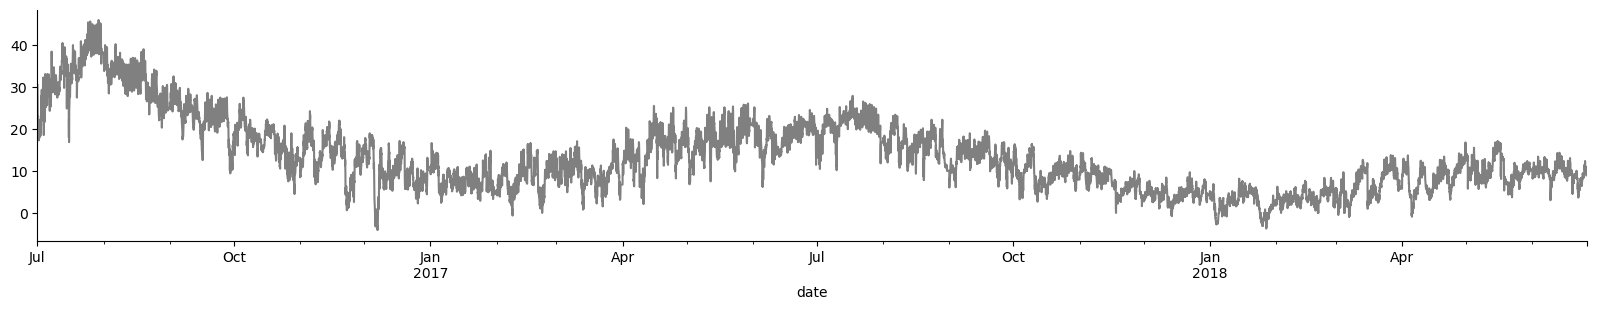

In [8]:
ax = df.OT.plot(color="gray", figsize=(20, 3))
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)

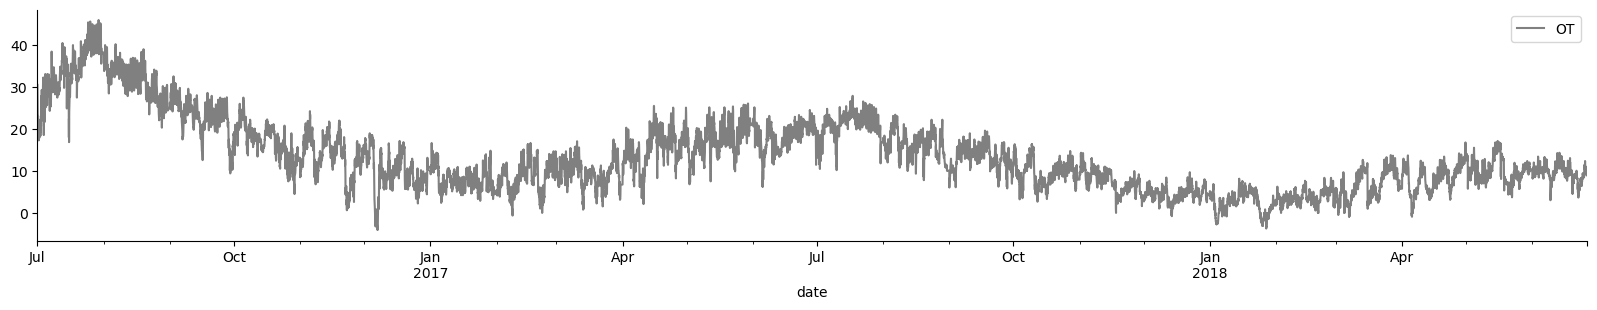

In [9]:
ax = df[["OT"]].plot(color="gray", figsize=(20, 3))
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
plt.show()

## Checking the data statistics

`.describe()` provide basic data statistics, this helps user to check and analyze whether distribution is skewed, how noisy is the data, and column wise value range. 

In [10]:
df.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000
mean,7.375141,2.242242,4.300239,0.881568,3.066062,0.856932,13.324672
std,7.067744,2.042342,6.826978,1.809293,1.164506,0.599552,8.566946
min,-22.705999,-4.756000,-25.087999,-5.934000,-1.188000,-1.371000,-4.080000
25%,5.827000,0.737000,3.296000,-0.284000,2.315000,0.670000,6.964000
50%,8.774000,2.210000,5.970000,0.959000,2.833000,0.975000,11.396000
75%,11.788000,3.684000,8.635000,2.203000,3.625000,1.218000,18.079000
max,23.643999,10.114000,17.341000,7.747000,8.498000,3.046000,46.007000


### Checking for missing values

`.isna()` checks whether any entry in the data frame is `NaN` or not. If value presents it returns False (0) else True (1). 
Thus summing all checks shows number of missing entry column wise.

In [11]:
df.isna().sum(axis=0)

HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

In scenarios where the data contains missing values, pandas `DataFrame` allows few simple methods for such data imputation.

```
DataFrame.fillna(value=None, *, method=None, axis=None, inplace=False, limit=None, downcast=_NoDefault.no_default)

Fill NA/NaN values using the specified method.
```

## Plotting Correlation across channels

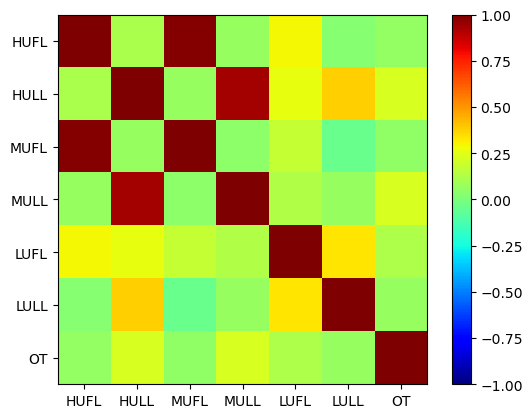

In [12]:
fig, ax = plt.subplots(1, 1)
cbar = ax.imshow(df.corr(), interpolation="nearest", vmin=-1, vmax=1, cmap="jet")
ax.set_xticks(np.arange(df.shape[1]), df.columns)
ax.set_yticks(np.arange(df.shape[1]), df.columns)
fig.colorbar(cbar)
plt.show()

## Computing Autocorrelation
Auto-correlation is the correlation computed between a series and its time-shifted version.
ACF auto-correlation function takes the series and a lag to produce an autocorrelation number.
An auto-correlation profile for a sequence, is it's auto-correlation values for a range of lag values.

In [13]:
def autocorr(x: np.ndarray, l: int):
    assert len(x.shape) == 1, f"Error: expects 1D array, received array size {x.shape}!"
    assert len(x) > l + 3, "Error: not sufficient data points for auto correlation computation!"

    x_ = x[l:]
    _x = x[:-l]
    return np.corrcoef(x_, _x)[0, 1]

In [14]:
def get_autocorr_profile(
    x: np.ndarray,
    max_lag: int = 40,
):
    c = [1.0]
    for l in range(max_lag):
        c.append(autocorr(x, l + 1))
    return np.array(c).astype(float)

In [15]:
max_lag = 1500
c_prof = get_autocorr_profile(df.OT.values, max_lag=max_lag)

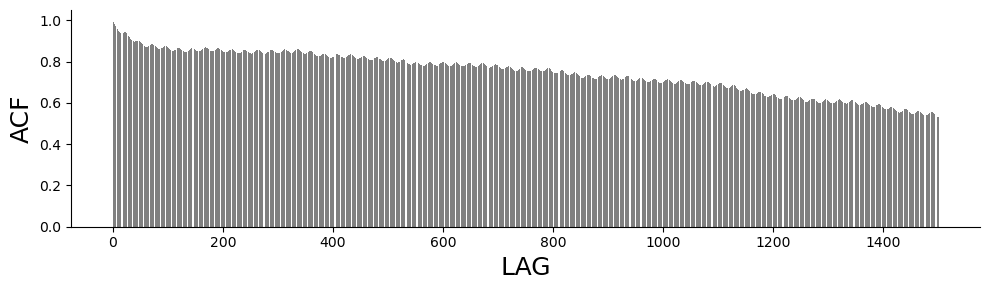

In [16]:
fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(1, 1, 1)
ax.bar(np.arange(max_lag + 1, dtype=float), c_prof, color="gray")
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
ax.set_xlabel("LAG", fontsize=18)
ax.set_ylabel("ACF", fontsize=18)
plt.tight_layout()
plt.show()

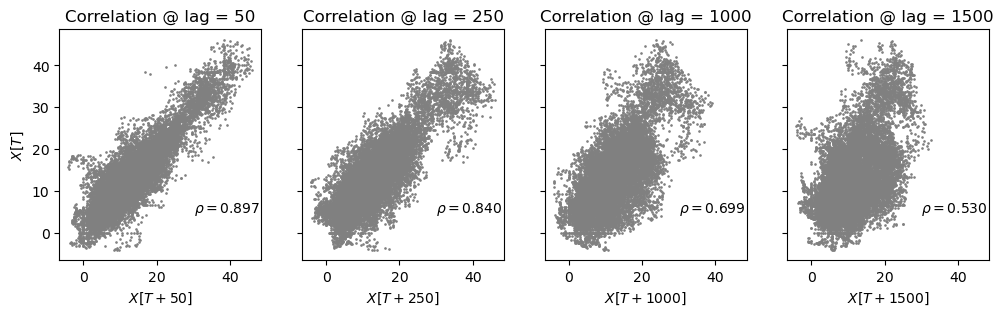

In [17]:
lags = [50, 250, 1000, 1500]
fig, axs = plt.subplots(1, len(lags), sharey=True, sharex=True, figsize=(3 * len(lags), 3))

for i, lag in enumerate(lags):
    r = np.corrcoef(df.OT.values[lag:], df.OT.values[:-lag])[0, 1]
    axs[i].scatter(df.OT.values[lag:], df.OT.values[:-lag], s=0.8, color="gray")
    if i == 0:
        axs[i].set_ylabel("$X[T]$")
    axs[i].set_xlabel(f"$X[T+{lag}]$")
    axs[i].set_title(f"Correlation @ lag = {lag}", fontsize=12)
    axs[i].text(x=30, y=5, s=f"$\\rho = ${r:.3f}")
plt.show()

## Partial Autocorrelation

Here we demonstrate how using Linear Regression model we can compute the partial autocorrelation score. 

In [19]:
from sklearn.linear_model import LinearRegression


def prepare_pacf_payload(x: np.ndarray, lag: int):
    assert len(x.shape) == 1, f"Error: expects 1D array recieved {x.shape}!"
    assert len(x) > lag + 3, "Error: not enough data for PACF!"

    n = len(x) - lag
    x_ = []
    for i in range(lag + 1):
        x_.append(x[i : (i + n)])
    x_ = np.array(x_).T
    x_, y_ = x_[..., :-1], x_[..., -1]
    return x_, y_


def pacf(x: np.ndarray, lag: int):
    x_, y_ = prepare_pacf_payload(x, lag)
    reg = LinearRegression(fit_intercept=True, copy_X=True)
    reg.fit(x_, y_)
    return np.concatenate([reg.coef_, [1.0]])[::-1]

In [20]:
max_lag = 25
c_prof = pacf(df.OT.values, lag=max_lag)

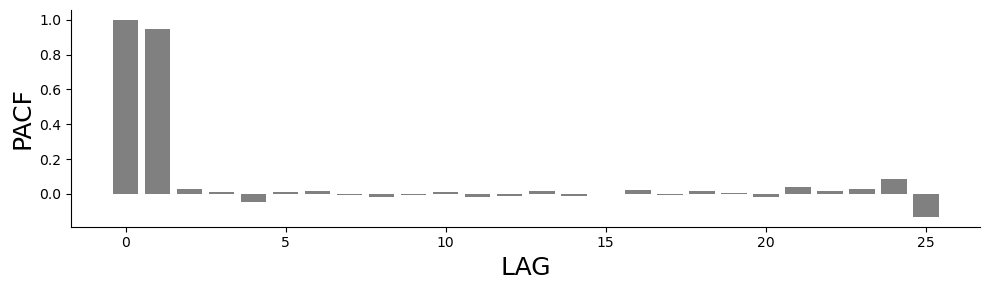

In [21]:
fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(1, 1, 1)
ax.bar(np.arange(max_lag + 1, dtype=float), c_prof, color="gray")
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
ax.set_ylabel("PACF", fontsize=18)
ax.set_xlabel("LAG", fontsize=18)
plt.tight_layout()

## Stationarity of Time Series

A stationarity time series is a time series, where its statistical property (viz., mean, variance) does not depends on the time. 

In [22]:
def mark_mean_over_window(x, window: int, window_stride: int, start_index: int = 5):
    n = len(x)
    start_index = min(max(start_index, 0), n - window)
    xs, ys = [], []

    while start_index + window < n:
        mean = np.mean(x[start_index : (start_index + window)])
        ys.append(mean)
        xs.append([start_index, start_index + window])
        start_index += window_stride
    return np.array(xs), np.array(ys)

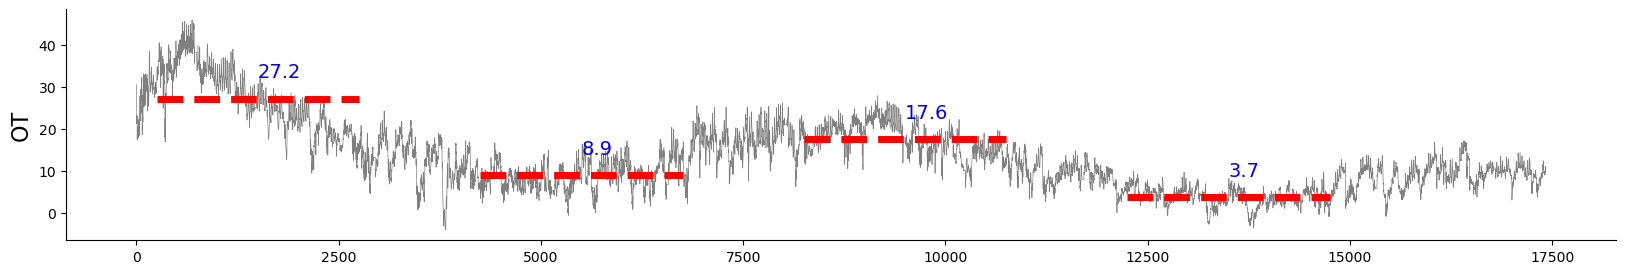

In [23]:
x = df.OT.values

fig, ax = plt.subplots(1, 1, figsize=(20, 3))
ax.plot(x, linewidth=0.5, color="gray")

xs, ys = mark_mean_over_window(x, window=2500, window_stride=4000, start_index=250)

for i in range(len(xs)):
    x_, y_ = xs[i], np.repeat(ys[i], 2)
    ax.plot(x_, y_, color="r", linewidth=5, linestyle="dashed")
    ax.text(x=np.mean(xs[i]), y=ys[i] + 5, s=f"{ys[i]:.1f}", fontsize=14, color="blue")

for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
ax.set_ylabel("OT", fontsize=16)
plt.show()

## Differencing Stationarize the time series data

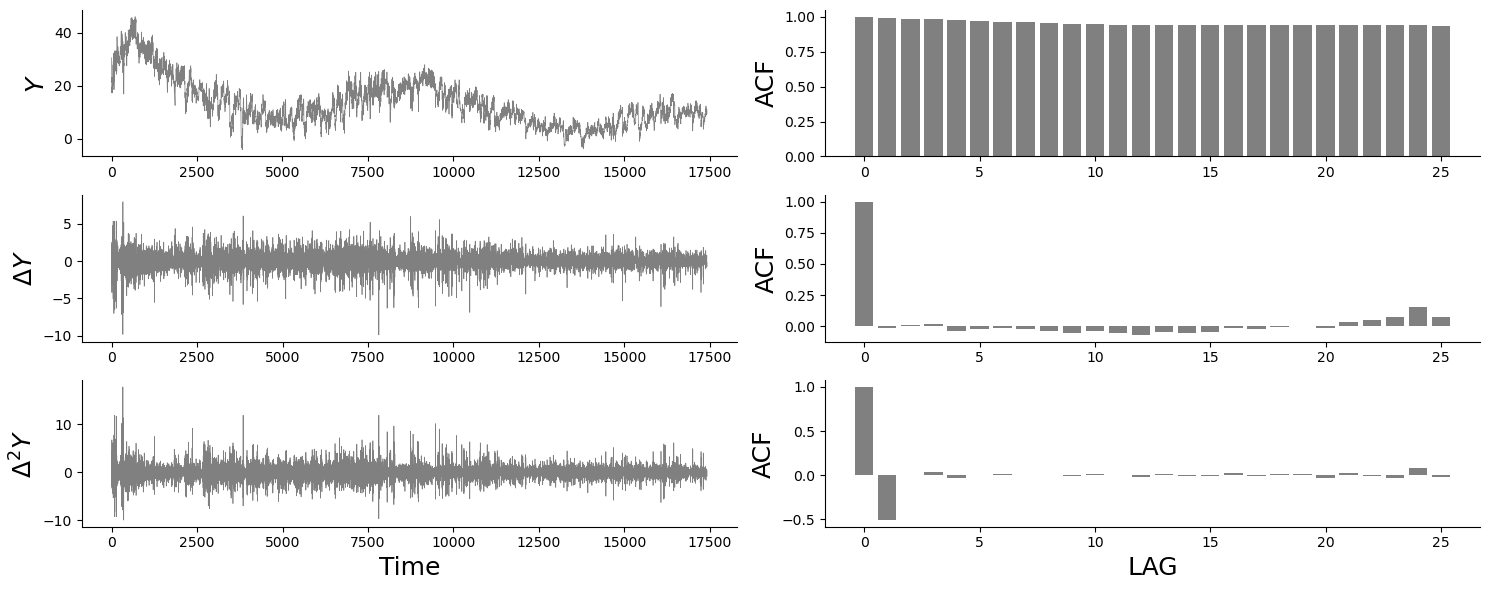

In [24]:
d = np.arange(3)
x = df.OT.values
y = np.arange(max_lag + 1, dtype=float)
c_profs = []
x_diffs = []
y_label = []
for i, d_ in enumerate(d):
    c_prof = get_autocorr_profile(x, max_lag=max_lag)
    x_diffs.append(x.copy())
    c_profs.append(c_prof)
    if i == 0:
        y_label.append("$Y$")
    elif i == 1:
        y_label.append(r"$\Delta Y$")
    else:
        y_label.append(rf"$\Delta^{i} Y$")
    x = np.diff(x)

fig = plt.figure(figsize=(15, 2 * len(c_profs)))
counter = 0
m, n = len(c_profs), 2
for c_prof, x_, ylab in zip(c_profs, x_diffs, y_label):
    ax = plt.subplot(m, n, counter + 1)
    ax.plot(x_, color="gray", linewidth=0.5)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.set_ylabel(ylab, fontsize=18)
    if counter // 2 == len(y_label) - 1:
        ax.set_xlabel("Time", fontsize=18)

    ax = plt.subplot(m, n, counter + 2)
    ax.bar(y, c_prof, color="gray")
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.set_ylabel("ACF", fontsize=18)
    if counter // 2 == len(y_label) - 1:
        ax.set_xlabel("LAG", fontsize=18)
    counter += 2
plt.tight_layout()
plt.show()